## Import Libraries

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2 as cv
import numpy as np
import torchvision.transforms as transforms
import torch 
import torch.nn.functional as F
from torch.utils.data import Dataset
import os
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as pl

## Import Dataset

Create a custome dataset loader

In [2]:
class custom_dataset_class(Dataset):
    def __init__(self, data_path, transform = None):
        self.data_paths = data_path
        self.data_list = os.listdir(data_path)
        self.transform = transform
        self.uniform = transforms.Compose([transforms.Resize((350,350)), transforms.ToTensor()])
        
    def __len__(self):
        return(len(self.data_list))
    
    def get_labels(self, filename):
        if filename[0:3] == "cat":
            return 0
        else:
            return 1
        
    def __getitem__(self,idx):
        file_path = os.path.join(self.data_paths,self.data_list[idx])
        image = Image.open(file_path)
        image_unf = self.uniform(image)
        if self.transform:
            image_unf = self.transform(image_unf)
        return image_unf,self.get_labels(self.data_list[idx])

In [3]:
t1=transforms.RandomPerspective(distortion_scale=0.2, p=0.2)
t2=transforms.RandomAffine(degrees=90, fill=(236, 209, 239), translate=(0.1, 0.1), scale=(0.8, 0.9))
t3=transforms.RandomRotation(degrees=(0, 180))

compt = transforms.Compose([t1,t2,t3])
cat_dog_dataset = custom_dataset_class(data_path="./Data/dogs-vs-cats/train/train/", transform=compt)

Text(0.5, 1.0, '1')

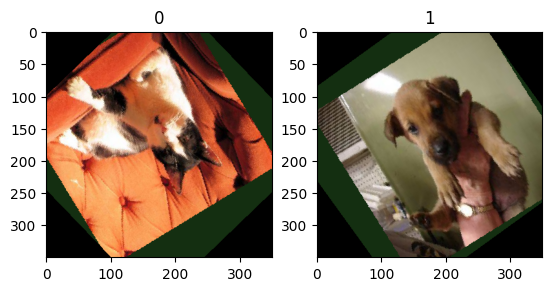

In [4]:
# Let us see a cat and dog to check if images are loaded correcly

img1 = cat_dog_dataset[999]
img2 = cat_dog_dataset[14500]

fig = plt.figure()
gs = gridspec.GridSpec(1,2)
ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(transforms.functional.to_pil_image(img1[0]))
ax1.set_title(img1[1])

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(transforms.functional.to_pil_image(img2[0]))
ax2.set_title(img2[1])

In [5]:
dataloader = DataLoader(
    cat_dog_dataset,
    batch_size=50,
    shuffle=True)

## Building CNN model

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv_layer2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv_layer3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.lin_layer1 = nn.Linear(118336, 150)
        self.lin_layer2 = nn.Linear(150,2)
        self.lin_layer3 = nn.Linear(50,2)
        
        self.max_pool1 = nn.MaxPool2d((2,2))
        self.max_pool2 = nn.MaxPool2d((2,2))
        self.max_pool3 = nn.MaxPool2d((2,2))
        
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.flat = nn.Flatten()

    def forward(self, x):
        #print("input shape {}".format(x.shape))
        x = self.conv_layer1(x)
        x = self.bn1(x)
        x = F.relu(x)
        #print("after conv 1 layer shape {}".format(x.shape))
        x = self.max_pool1(x)
        #print("after max pool shape {}".format(x.shape))
        
        x = self.conv_layer2(x)
        #print("after conv 2 layer shape {}".format(x.shape))
        x = self.bn2(x)
        x = F.relu(x)
        
        x = self.max_pool2(x)
        #print("after max 2 layer shape {}".format(x.shape))
        
        x = self.conv_layer3(x)
        x = self.bn3(x)
        #print("after conv 3 layer shape {}".format(x.shape))
        x = F.relu(x)
        x = self.max_pool3(x)
        #print("after max layer 3 shape {}".format(x.shape))
        
        x = self.flat(x)
        print("after flattening the shape {}".format(x.shape))
        
        
        x = self.lin_layer1(x)
        x = F.relu(x)
        x = self.lin_layer2(x)
        #x = F.relu(x)
        #x = self.lin_layer3(x)
        return x

In [7]:
#Test on one image
model = CNN()
model(img1[0].unsqueeze(0)).shape

after flattening the shape torch.Size([1, 118336])


torch.Size([1, 2])

In [8]:
for name, param in model.named_parameters():
    print(name,param.grad)

conv_layer1.weight None
conv_layer1.bias None
conv_layer2.weight None
conv_layer2.bias None
conv_layer3.weight None
conv_layer3.bias None
lin_layer1.weight None
lin_layer1.bias None
lin_layer2.weight None
lin_layer2.bias None
lin_layer3.weight None
lin_layer3.bias None
bn1.weight None
bn1.bias None
bn2.weight None
bn2.bias None
bn3.weight None
bn3.bias None


In [9]:
model2 = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr = 0.001)
        

num_epoch = 10

for epoch in range(num_epoch):
    model2.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    batch = 0
    print("iteration epoch = {0}".format(epoch))
    for img, label in dataloader:
        
        #for name, param in model.named_parameters():
            #print(f"{name}: requires_grad={param.requires_grad}")
        
        batch += 1
        #print("iteration epoch = {0} and batch = {1}".format(epoch,batch))
        
        temp_image = img
        temp_label = label
        
        outputs = model2(temp_image)
        
        loss = criterion(outputs,temp_label)
        
        optimizer.zero_grad()
        loss.backward()

        # ----- GRADIENT CHECK -----
        total_norm = 0.0
        for name, param in model2.named_parameters():
            if param.grad is not None:
                grad_norm = param.grad.data.norm(2).item()
                total_norm += grad_norm ** 2
                print(f"Grad norm - {name}: {grad_norm:.6f}")
        total_norm = total_norm ** 0.5
        print(f"Total grad norm: {total_norm:.6f}")
        
        torch.nn.utils.clip_grad_norm_(model2.parameters(), max_norm= 15)
        
        optimizer.step()

        # 4. Track stats
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += temp_label.size(0)
        #print(predicted.shape)
        #print(labels.shape)
        correct += (predicted == temp_label).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epoch}] Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}")

        

iteration epoch = 0
after flattening the shape torch.Size([50, 118336])
Grad norm - conv_layer1.weight: 0.503443
Grad norm - conv_layer1.bias: 0.000014
Grad norm - conv_layer2.weight: 0.443847
Grad norm - conv_layer2.bias: 0.000174
Grad norm - conv_layer3.weight: 0.741969
Grad norm - conv_layer3.bias: 0.000028
Grad norm - lin_layer1.weight: 15.115432
Grad norm - lin_layer1.bias: 0.042245
Grad norm - lin_layer2.weight: 0.577437
Grad norm - lin_layer2.bias: 0.100411
Grad norm - bn1.weight: 0.016385
Grad norm - bn1.bias: 0.012338
Grad norm - bn2.weight: 0.025023
Grad norm - bn2.bias: 0.010211
Grad norm - bn3.weight: 0.034072
Grad norm - bn3.bias: 0.020169
Total grad norm: 15.159989
after flattening the shape torch.Size([50, 118336])
Grad norm - conv_layer1.weight: 32.577988
Grad norm - conv_layer1.bias: 0.000803
Grad norm - conv_layer2.weight: 33.956570
Grad norm - conv_layer2.bias: 0.007582
Grad norm - conv_layer3.weight: 43.121490
Grad norm - conv_layer3.bias: 0.000264
Grad norm - lin_l

KeyboardInterrupt: 